In [1]:
import os
root = os.path.join('..')
data_root = os.path.join(root, 'data')
dataset_root = os.path.join(root, '..', 'datasets')
fig_root = os.path.join(root, 'figs')

import sys
sys.path.append(root)

In [2]:
from typing import Dict, Union

import torch
import torchvision.transforms as T

from utils.data import (CIFAR10, FMNIST, MNIST, extract_all_data,
                        select_data_and_labels_binary)
from utils.fig import Axes, Figure

In [3]:
Figure.set_seaborn_theme()
Figure.set_tex()
Figure.set_high_dpi()

In [4]:
def calc_statistics(dataset: Union[MNIST, FMNIST, CIFAR10]) -> Dict:
    all_data, all_labels = extract_all_data(dataset, False)

    binary_classes = [(i, j) for i in range(10) for j in range(i+1, 10)]

    exp_sorted_memory = torch.empty(len(binary_classes), dataset.dim)
    cov_row_sum_sorted_memory = torch.empty(len(binary_classes), dataset.dim)

    for idx, (i, j) in enumerate(binary_classes):

        data, labels = select_data_and_labels_binary(all_data, all_labels, i, j)
        data = data.flatten(1)

        data -= data.mean(0)
        yx = (data * labels[:, None]).sum(0).sign() * labels[:, None] * data

        exp = yx.mean(0)
        cov = yx.T.cov(correction=0)
        cov_row_sum = cov.sum(1)

        exp_sorted = exp.sort(descending=True)[0]
        cov_row_sum_sorted = cov_row_sum.sort(descending=True)[0]

        exp_sorted_memory[idx] = exp_sorted
        cov_row_sum_sorted_memory[idx] = cov_row_sum_sorted

    exp_mean = exp_sorted_memory.mean(0)
    exp_std = exp_sorted_memory.std(0, correction=0)

    cov_mean = cov_row_sum_sorted_memory.mean(0)
    cov_std = cov_row_sum_sorted_memory.std(0, correction=0)

    return {
        'exp_mean': exp_mean,
        'exp_std': exp_std,
        'cov_mean': cov_mean,
        'cov_std': cov_std,
    }

In [5]:
mnist = MNIST(dataset_root, True)
mnist_statistics = calc_statistics(mnist)

fmnist = FMNIST(dataset_root, True)
fmnist_statistics = calc_statistics(fmnist)

cifar10 = CIFAR10(dataset_root, True, T.ToTensor())
cifar10_statistics = calc_statistics(cifar10)

Files already downloaded and verified


In [6]:
def embed(dataset: Union[MNIST, FMNIST, CIFAR10], statistics: Dict, eps: float, ax1: Axes, ax2: Axes) -> None:
    x = range(dataset.dim)

    ax1.line_with_band(x, statistics['exp_mean'], statistics['exp_std'], linewidth=2, label=r'$\mathbb{E}[yx_i]$')

    ax1.hline(eps, 0, dataset.dim, colors=Figure.palette[1], label=r'$\epsilon={}$'.format(eps)) # type: ignore

    ax1_ymin = (statistics['exp_mean'] - statistics['exp_std']).min().item()
    ax1_ymax = (statistics['exp_mean'] + statistics['exp_std']).max().item()

    eps_x = torch.nonzero(statistics['exp_mean'] < eps)[0, 0].item()
    ax1.vline(eps_x, ax1_ymin, ax1_ymax, colors=Figure.palette[2], linestyles='dashed') # type: ignore

    ax1.set_xticks([0, eps_x, dataset.dim])
    ax1.set_yticks_strformat('{x:.1f}')

    ax1.set_title(dataset.name, fontsize=Figure.get_global_param('axes.titlesize')-1)

    ax2.line_with_band(x, statistics['cov_mean'], statistics['cov_std'], linewidth=2, label=r'$\sum^d_j \operatorname{Cov}(x_i, x_j)$')

    ax2_ymin = (statistics['cov_mean'] - statistics['cov_std']).min().item()
    ax2_ymax = (statistics['cov_mean'] + statistics['cov_std']).max().item()

    cov_x = torch.nonzero(statistics['cov_mean'] < 0)[0, 0].item()
    ax2.vline(cov_x, ax2_ymin, ax2_ymax, colors=Figure.palette[2], linestyles='dashed') # type: ignore

    ax2.set_xticks([0, cov_x, dataset.dim])
    ax2.set_yticks([0])

    ax2.set_xlabel(r'Sorted dimension $i$', fontsize=Figure.get_global_param('axes.labelsize')-1)

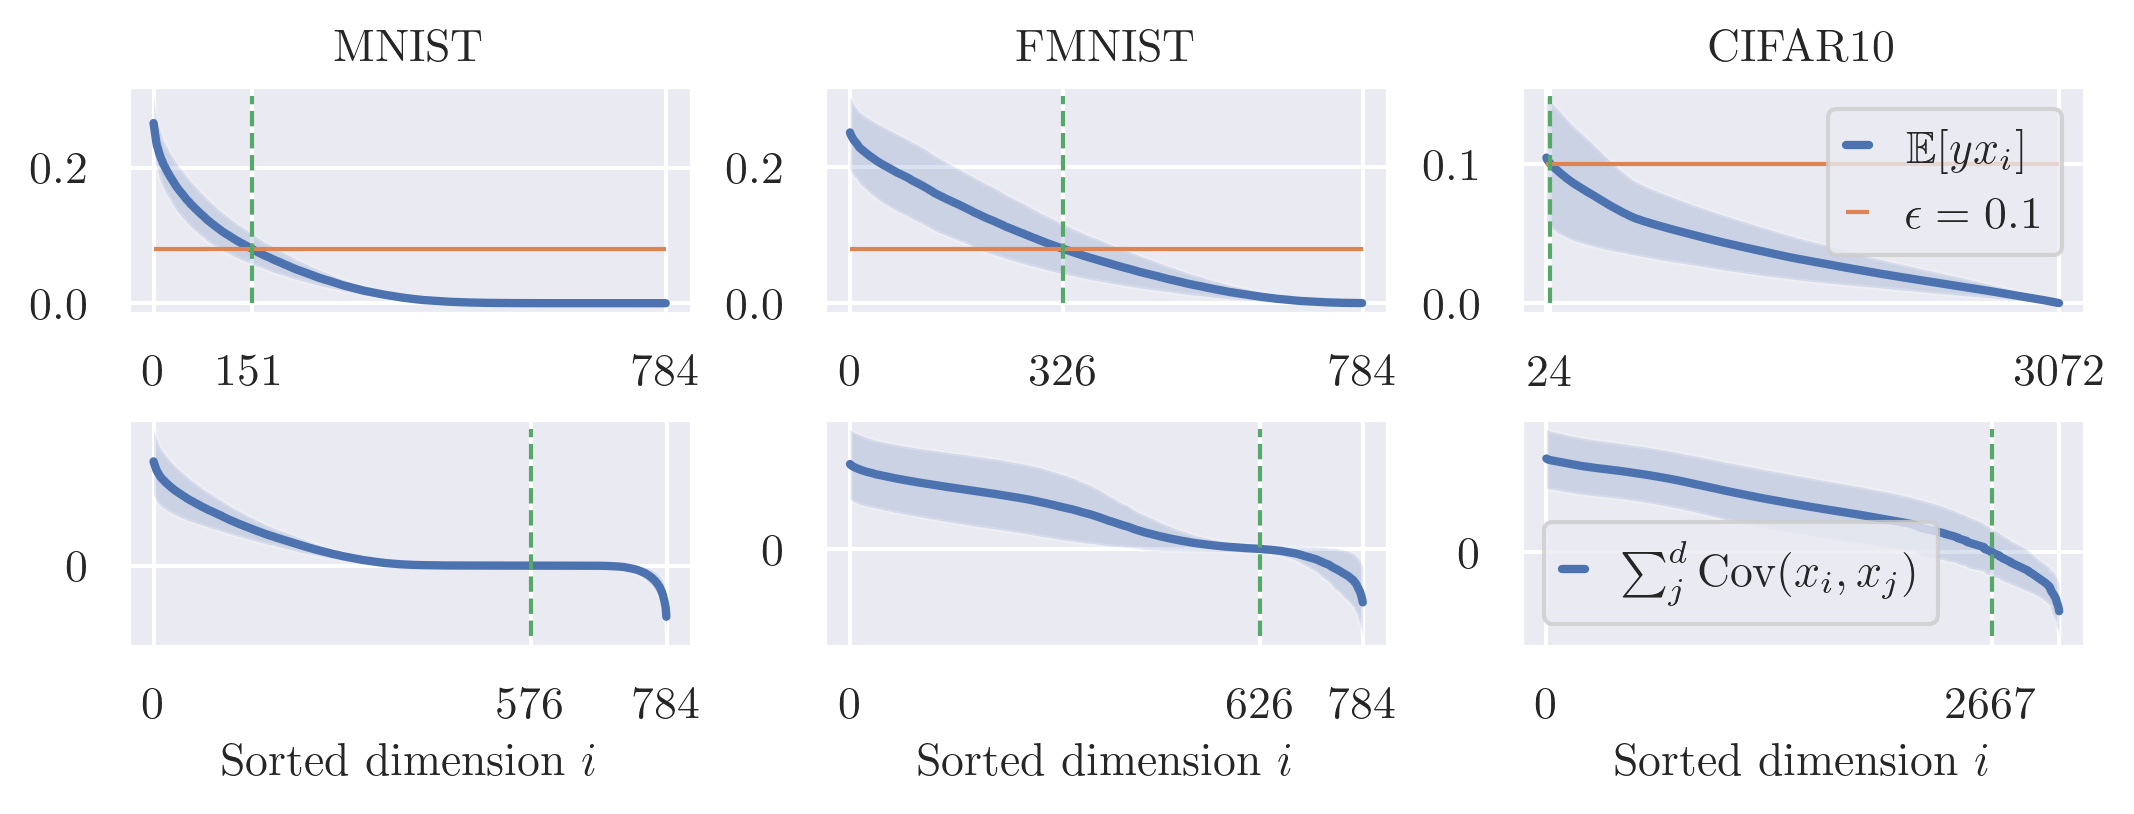

In [7]:
f = Figure(2, 3, (7, 2.6))

embed(mnist, mnist_statistics, .1, f.axes[0][0], f.axes[1][0])
embed(fmnist, fmnist_statistics, .1, f.axes[0][1], f.axes[1][1])
embed(cifar10, cifar10_statistics, .1, f.axes[0][2], f.axes[1][2])

f.axes[0][2].legend(handlelength=.5)
f.axes[1][2].legend(handlelength=.5)

xticklabels = f.axes[0][2].get_xticklabels()
xticklabels[0] = '' # type: ignore
f.axes[0][2].set_xticklabels(xticklabels)

xticklabels = f.axes[1][2].get_xticklabels()
xticklabels[-1] = '' # type: ignore
f.axes[1][2].set_xticklabels(xticklabels)

f.save(fig_root, 'datasets.pdf')
f.show()